In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize

import shap

/Users/raulbag/miniforge3/envs/xai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import shap

# ---------- AR(p) MLE pieces (same as before, with the sign fix) ----------
def neg_log_likelihood(params, x, p):
    phi = params[:p]
    sigma2 = params[-1]
    if sigma2 <= 0:
        return np.inf
    T = len(x)
    residuals = []
    for t in range(p, T):
        x_pred = np.dot(phi, x[t-p:t][::-1])
        residuals.append(x[t] - x_pred)
    residuals = np.asarray(residuals)
    n = residuals.size
    loglik = -0.5 * n * np.log(2*np.pi*sigma2) - 0.5 * np.sum(residuals**2)/sigma2
    return -loglik

def mle_estimator_ar(x, p=3):
    init_phi = np.zeros(p)
    init_sigma2 = np.var(x, ddof=min(p, max(1, len(x)-1))) if len(x) > p else np.var(x)
    init_params = np.concatenate([init_phi, [max(init_sigma2, 1e-3)]])
    bounds = [(-1.5, 1.5)] * p + [(1e-6, None)]
    res = minimize(neg_log_likelihood, init_params, args=(x, p), bounds=bounds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError(f"MLE failed: {res.message}")
    return res.x  # [phi_1,...,phi_p, sigma^2]

def make_lag_matrix(series, p=3):
    x = np.asarray(series)
    rows = [x[t-p:t][::-1] for t in range(p, len(x))]
    return np.asarray(rows)

# ---------- Helper to read/normalize the dynamic window plan ----------
def _load_window_plan(window_plan, column_name="window"):
    """
    Accepts:
      - None (no plan)
      - str (csv path)
      - pd.DataFrame (must contain a 'window' column; index is the integer 'date index')
    Returns:
      dict: {int_index: int_rounded_window}
    """
    if window_plan is None:
        return None

    if isinstance(window_plan, str):
        # First column is the 'date index'
        df = pd.read_csv(window_plan, index_col=0)
    elif isinstance(window_plan, pd.DataFrame):
        df = window_plan.copy()
        # If the first unnamed column is the index, set it as index
        if df.index.name is None and df.columns[0].lower() in {"index", "unnamed: 0"}:
            df = df.set_index(df.columns[0])
    else:
        raise TypeError("window_plan must be None, a CSV filepath, or a pandas DataFrame")

    # Ensure the column exists
    if column_name not in df.columns:
        # allow fallback if the sole column is the window values
        if df.shape[1] == 1:
            df.columns = [column_name]
        else:
            raise ValueError(f"Expected a '{column_name}' column in the window plan.")

    # Build mapping: integer position -> rounded window
    plan = {}
    for idx, val in df[column_name].items():
        try:
            pos = int(idx)
            plan[pos] = int(round(float(val)))
        except Exception:
            # skip rows with bad indices/values
            continue
    return plan if plan else None

# ---------- Main function with dynamic windowing + SHAP ----------
def rolling_ar3_with_shap(
    data: pd.Series,
    default_window: int = 100,
    window_plan=None,              # CSV path or DataFrame with 'window' column and integer index
    p: int = 3,
    background_cap: int = 50       # cap background rows to speed up Kernel SHAP
):
    """
    data: pd.Series with a (time) index.
    default_window: used when no plan is provided for a time index.
    window_plan: CSV path or DataFrame with columns=['window']; index is the integer 'date index'.
    p: AR order (fixed to 3 per your use case).
    background_cap: limit background rows for KernelExplainer for speed.
    """
    plan = _load_window_plan(window_plan)

    # We need at least p+3 observations to form:
    # - AR(p) fit
    # - a non-degenerate background (>= p rows ideally)
    min_needed = p + 3

    results = []
    n = len(data)

    # Start at the earliest index where default_window would work;
    # but dynamic plan can request smaller/larger windows, so we validate per-step.
    start = max(default_window, min_needed)
    for i in range(start, n):
        # pick dynamic window if available at this position, else default
        w = plan.get(i, default_window) if plan else default_window
        # enforce validity
        w = max(min_needed, min(w, i))  # must be <= i and >= p+3
        if w < min_needed:
            continue  # just in case

        window = data.iloc[i - w:i]

        # Fit AR(3)
        theta = mle_estimator_ar(np.asarray(window), p=p)
        coeffs = theta[:-1]

        # Build current feature vector (lags)
        X = np.array([[window.iloc[-1], window.iloc[-2], window.iloc[-3]]])

        # Background for SHAP: lag rows from this window
        B = make_lag_matrix(window, p=p)
        if B.shape[0] == 0:
            # fallback to zero background (rare if w >= p+3), but keep shape
            B = np.zeros((1, p))
        elif B.shape[0] > background_cap:
            B = B[-background_cap:]  # take the most recent rows

        def f(Z):
            return Z @ coeffs

        explainer = shap.KernelExplainer(f, B)
        shap_vals = explainer.shap_values(X, nsamples="auto", silent=True)  # (1, p)

        results.append({
            "date": data.index[i],
            "i": i,
            "window_used": int(w),
            "actual": float(data.iloc[i]),
            "ar1": float(coeffs[0]),
            "ar2": float(coeffs[1]),
            "ar3": float(coeffs[2]),
            "shap_ar1": float(shap_vals[0, 0]),
            "shap_ar2": float(shap_vals[0, 1]),
            "shap_ar3": float(shap_vals[0, 2]),
        })

    return pd.DataFrame(results)


In [13]:
df = pd.read_csv("data.csv")
# r = rolling_ar3_with_shap(df['N'], default_window=300) # use this for simple rolling window

# Case B: with a DataFrame like the one you showed
window_size = pd.read_csv("window_size.csv", index_col=0)  # index is the date index, column 'window'
r = rolling_ar3_with_shap(df['N'], window_plan=window_size, default_window=4)

In [14]:
print(r)

      date     i  window_used    actual       ar1       ar2       ar3  \
0        6     6            6  1.475974  0.646003 -1.500000  0.000000   
1        7     7            6  1.466507  0.646003 -1.500000  0.364298   
2        8     8            6  1.030595  0.126984 -0.374786 -1.500000   
3        9     9            7  0.661385  1.214323 -0.768868  0.137788   
4       10    10            8 -0.752025  1.271499 -0.805903  0.265195   
...    ...   ...          ...       ...       ...       ...       ...   
1489  1495  1495          500  2.622981 -0.019931  0.035498  0.876748   
1490  1496  1496          500  2.710518 -0.018431  0.033951  0.875265   
1491  1497  1497          500 -0.890049 -0.019896  0.033546  0.873651   
1492  1498  1498          500  2.123876 -0.016748  0.036345  0.871293   
1493  1499  1499          500  2.684472 -0.017658  0.034781  0.870082   

      shap_ar1  shap_ar2  shap_ar3  
0     0.983057  0.721636  0.000000  
1     1.080280 -2.282630 -0.175261  
2     0.1136

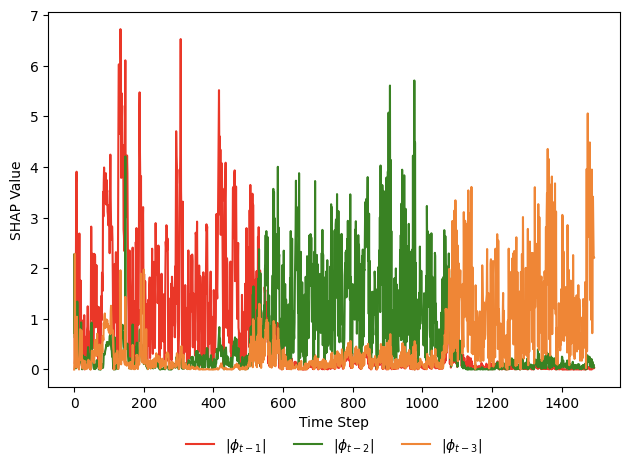

In [17]:
plt.plot(np.abs(r['shap_ar1']), label='$|\\phi_{t-1}|$', color='#EA3728')
plt.plot(np.abs(r['shap_ar2']), label='$|\\phi_{t-2}|$', color='#398223')
plt.plot(np.abs(r['shap_ar3']), label='$|\\phi_{t-3}|$', color='#EF8636')

data_length = len(r['shap_ar1'].values)

# Set x-ticks to start from 301. This is only required 
# x_positions = np.arange(0, data_length, step=300)  # Adjust step as needed
# x_labels = np.arange(300, 300 + data_length, step=300)  # Labels starting from 301
# plt.xticks(x_positions, x_labels)

# plt.plot(df_subset.index, df_subset['Predicted'], label='Predicted', color='red')
plt.xlabel('Time Step')
plt.ylabel('SHAP Value')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, frameon=False)
plt.tight_layout()
plt.savefig("shap_ar_adaptive_window.png", format='png', dpi=600, transparent=True)
plt.show()